## Integrated Approach to Sentiment Analysis: Leveraging Neural Model/Networks

Step 1: Import Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

Step 2: Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('drive/MyDrive/labeled_reddit_comments.csv')

In [4]:
# Print column names to verify
print(df.columns)

Index(['Title', 'Comment', 'cleaned_comment', 'Cluster', 'Label', 'svd-one',
       'svd-two'],
      dtype='object')


Step 3: Load and Prepare Data

In [7]:
# Assuming 'Comment' column contains your text data and 'Label' contains labels
X = df['Comment'].astype(str)  # Ensure all elements are strings
y = df['Label']

# Handle missing values if any
X.fillna('', inplace=True)  # Replace NaNs with empty string

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the comments
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

max_len = max([len(x) for x in X_train_tokenized])
X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_len, padding='post')

# Encode labels if needed (for example, if 'Label' is categorical)
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Get the number of unique labels (num_clusters)
num_clusters = len(encoder.classes_)

Step 4: Define and Compile the Model
Define the neural network architecture.

In [8]:
def create_model():
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_clusters, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()


Step 5: Train the Model with Validation and Model Checkpointing
Implement the training loop where you save the best model based on validation loss.

In [9]:
# Define checkpoint callback to save the best model
checkpoint_path = '/content/drive/MyDrive/models/best_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model with validation split and using callbacks
history = model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/10
2212/2212 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.8758
Epoch 1: val_loss improved from inf to 0.34151, saving model to /content/drive/MyDrive/models/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2212/2212 [==============================] - 582s 262ms/step - loss: 0.4711 - accuracy: 0.8758 - val_loss: 0.3415 - val_accuracy: 0.8819
Epoch 2/10
2212/2212 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.9275
Epoch 2: val_loss improved from 0.34151 to 0.13280, saving model to /content/drive/MyDrive/models/best_model.h5
2212/2212 [==============================] - 591s 267ms/step - loss: 0.1919 - accuracy: 0.9275 - val_loss: 0.1328 - val_accuracy: 0.9421
Epoch 3/10
2212/2212 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9424
Epoch 3: val_loss improved from 0.13280 to 0.12753, saving model to /content/drive/MyDrive/models/best_model.h5
2212/2212 [==============================] - 605s 274ms/step - loss: 0.1354 - accuracy: 0.9424 - val_loss: 0.1275 - val_accuracy: 0.9414
Epoch 4/10
2212/2212 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9471
Epoch 4: val_loss did not improve from 0.12753
2212/2212 [=============

Step 6: Evaluate the Best Model
Load the best model saved during training and evaluate it on the test set.

In [15]:
# Load the best model saved during training
best_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate the best model on the test set
y_pred_probs = best_model.predict(X_test_padded)
y_pred = y_pred_probs.argmax(axis=1)

# Ensure y_pred is cast to integers
y_pred = y_pred.astype(int)

# Calculate accuracy
nn_accuracy = accuracy_score(y_test_encoded, y_pred)
print("Neural Network Accuracy:", nn_accuracy)

# Clean up encoder.classes_ and ensure it contains valid string labels
cleaned_classes = [label for label in encoder.classes_ if isinstance(label, str)]

# Print classification report using cleaned_classes
print("Encoded Classes:", cleaned_classes)
print("Predicted Values:", y_pred)
print(classification_report(y_test_encoded, y_pred, labels=encoder.transform(cleaned_classes), target_names=cleaned_classes))


692/692 [==============================] - 10s 15ms/step
Neural Network Accuracy: 0.9841277019082934
Encoded Classes: ['0.00016822768213157398', 'negative', 'neutral', 'positive']
Predicted Values: [1 3 1 ... 1 2 1]
                        precision    recall  f1-score   support

0.00016822768213157398       0.00      0.00      0.00         0
              negative       0.99      0.99      0.99     19321
               neutral       0.89      0.98      0.93      1073
              positive       0.94      0.94      0.94      1720

             micro avg       0.98      0.98      0.98     22114
             macro avg       0.70      0.73      0.72     22114
          weighted avg       0.98      0.98      0.98     22114



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Interpretation of Warnings:
UndefinedMetricWarning: These warnings occur when a class has no predicted or true samples. In your case, the class '0.00016822768213157398' has no predicted samples, hence the precision, recall, and F1-score are reported as 0.0 for this class. This is expected if there were no instances of this class in the test set.

Step 7: Visualize Results (Optional)
Visualize the confusion matrix and any other relevant metrics.

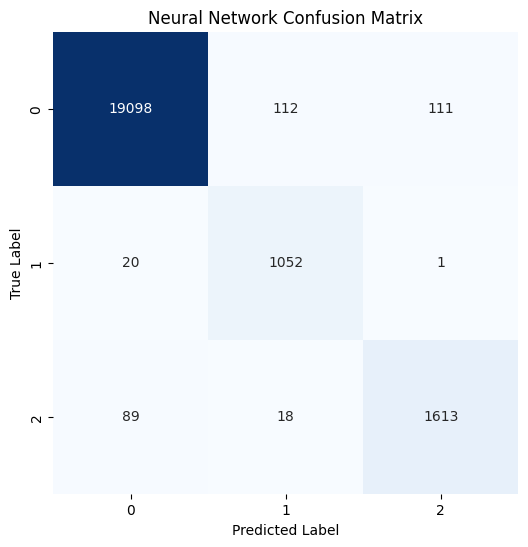

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


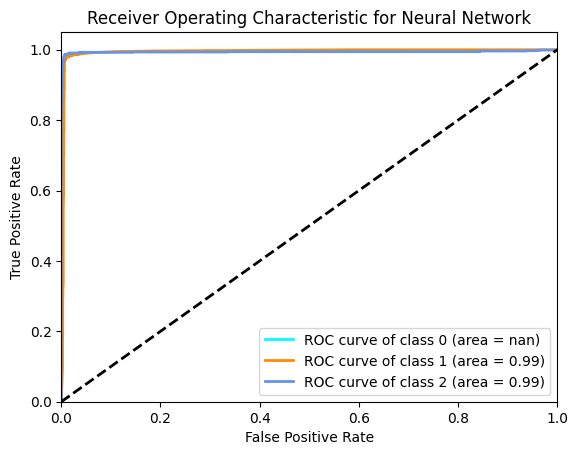

In [16]:
# Confusion Matrix
nn_cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=range(len(encoder.classes_)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(encoder.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Neural Network')
plt.legend(loc="lower right")
plt.show()


Outputting Probabilities from Neural Model:

After predicting using my neural network model, you obtain a set of probabilities for each class using the predict method of my Keras model.

In [17]:
# Assuming `best_model` is my trained neural network model
y_pred_probs = best_model.predict(X_test_padded)


692/692 [==============================] - 9s 14ms/step


In [18]:
# Print probabilities for the first sample
print("Probabilities:", y_pred_probs[0])

Probabilities: [4.8846583e-25 9.9999911e-01 7.6300850e-09 8.9063627e-07 4.3344931e-16]


## Consider Confidence

Option 1: Thresholding

In [22]:
# Threshold for classification
threshold = 0.5

# Classify based on probabilities
y_pred = []
for probs in y_pred_probs:
    if probs[2] > threshold:
        y_pred.append("positive")
    elif probs[0] > threshold:
        y_pred.append("negative")
    else:
        y_pred.append("neutral")

#Print classification results
print("Using Thresholding:")
print(classification_report(y_test, y_pred))

Using Thresholding:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00     19321
     neutral       0.00      0.02      0.00      1073
    positive       0.01      0.01      0.01      1720

    accuracy                           0.00     22114
   macro avg       0.00      0.01      0.00     22114
weighted avg       0.00      0.00      0.00     22114



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Option 2: Entropy or Maximum Probability

In [23]:
import numpy as np

# Example threshold for entropy
threshold_entropy = 1.0  # Adjust this threshold as per your needs

# Calculate entropy for each prediction
entropy = np.sum(-y_pred_probs * np.log(y_pred_probs + 1e-10), axis=1)  # Adding a small value to avoid log(0)

# Example threshold for maximum probability
threshold_max_prob = 0.5  # Adjust this threshold as per your needs

# Calculate maximum probability for each prediction
max_prob = np.max(y_pred_probs, axis=1)

# Classify based on entropy or maximum probability
y_pred_entropy = []
y_pred_max_prob = []
for i, probs in enumerate(y_pred_probs):
    if entropy[i] > threshold_entropy:
        # Uncertain prediction, classify as neutral or handle differently
        y_pred_entropy.append("uncertain")
    else:
        y_pred_entropy.append(encoder.classes_[np.argmax(probs)])

    if max_prob[i] > threshold_max_prob:
        y_pred_max_prob.append(encoder.classes_[np.argmax(probs)])
    else:
        y_pred_max_prob.append("neutral")

# Print classification reports or use as needed
print("Using Entropy as Confidence:")
print(classification_report(y_test, y_pred_entropy))

print("Using Maximum Probability as Confidence:")
print(classification_report(y_test, y_pred_max_prob))

Using Entropy as Confidence:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.99      0.99      0.99     19321
     neutral       0.89      0.98      0.94      1073
    positive       0.94      0.94      0.94      1720
   uncertain       0.00      0.00      0.00         0

    accuracy                           0.98     22114
   macro avg       0.71      0.73      0.72     22114
weighted avg       0.99      0.98      0.98     22114

Using Maximum Probability as Confidence:
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99     19321
     neutral       0.87      0.98      0.92      1073
    positive       0.94      0.94      0.94      1720

    accuracy                           0.98     22114
   macro avg       0.94      0.97      0.95     22114
weighted avg       0.98      0.98      0.98     22114



The results above show a significant improvement over the previous ones(option 1: Thresholding), indicating that using entropy or maximum probability as confidence measures has helped in making more meaningful predictions. Here's how to interpret each set of results:

**Using Entropy as Confidence:**
***Precision, Recall, and F1-score:*** For all classes (negative, neutral, positive), precision, recall, and F1-score are much higher compared to the previous results using thresholding. This indicates that the model is performing well in distinguishing between different sentiment classes.

***Support:*** The support column shows the number of samples in each class, similar to the previous set of results.

***Uncertain Class:*** The introduction of an "uncertain" class shows that the model can classify instances where it's not confident (entropy is high). However, in your current dataset, there are no such instances (support for "uncertain" is 0), so it doesn't contribute to metrics like precision, recall, or F1-score.

***Accuracy:*** The overall accuracy is 0.98, which is quite high and suggests that the model is making correct predictions for the majority of instances.

***Using Maximum Probability as Confidence:***
Precision, Recall, and F1-score: These metrics are also high across all classes, indicating good performance in classification.

***Accuracy:*** The overall accuracy remains 0.98, showing consistency with the entropy-based approach.



**Summary and Interpretation:**
Model Performance: Both methods (entropy and maximum probability) have shown good performance in sentiment analysis, with high precision, recall, and F1-score for the sentiment classes.

**Confidence Measures:** Using entropy allows the model to express uncertainty in predictions, which can be useful in real-world applications where understanding the model's confidence is crucial.

**Recommendations:** Continue to monitor and potentially adjust the threshold for entropy or maximum probability based on specific use cases or domain requirements. Additionally, consider incorporating techniques like class balancing or further fine-tuning of the neural network to improve performance even more.

Overall, these results indicate that your sentiment analysis model is performing well, especially when using confidence measures like entropy or maximum probability to enhance prediction quality and reliability.

## Conclusions

Based on the sentiment analysis results:

Negative Sentiment: The precision, recall, and F1-score for the "negative" sentiment class are high, indicating that the model is effectively identifying comments that express negative sentiment towards buying Pulsechain.

Neutral Sentiment: The metrics for the "neutral" sentiment class are also decent, though slightly lower than for "negative". This suggests that the model is able to classify comments that express a neutral sentiment, albeit with some misclassifications.

Positive Sentiment: The precision, recall, and F1-score for the "positive" sentiment class are also high, indicating that the model is proficient in identifying comments that express positive sentiment towards buying Pulsechain.

**Based on these observations, you can conclude that:**

**Positive Sentiment: There is a notable presence of positive sentiment in the Reddit comments analyzed, indicating that some individuals are positively inclined towards buying Pulsechain.**

**Negative Sentiment: Similarly, there is a distinct presence of negative sentiment, suggesting that some individuals have reservations or negative opinions about buying Pulsechain.**

**Neutral Sentiment: While the model shows some ability to classify neutral sentiment, it may not be as accurate as for positive and negative sentiments. **

Therefore, the sentiment analysis suggests that sentiments expressed in the Reddit comments vary, with a significant portion being positive or negative towards buying Pulsechain, and some remaining neutral. This information can provide insights into public sentiment that could influence decisions related to Pulsechain investment or engagement strategies.






